<img src='../images/hanzi_hero_icon.png' style="float: left; margin: 20px; height: 55px">

# Hanzi Hero: Empowering Kids to Master Chinese Characters
<div style="text-align: right"> <H3> By Jayme Zhang </div>

---

## 3. Self-Trained CNN Model - Multiclass

In the previous notebook [02_Self_Trained_Model_Binary](02_Self_Trained_Model_Binary.ipynb), we have seen reasonable success in building a binary image recognition model to classify handwritten Chinese character for `我`, which means me/ myself/ I.
  
For this notebook, we will make use of the same network architecture to build a multiclass classifier for 10 Chinese characters.
  
The Chinese characters chosen for this task are:
  
1. `你` - you
2. `吃` - eat
3. `妈` - mother
4. `家` - family/ home
5. `我` - me/ myself/ I
6. `爱` - love
7. `爸` - father
8. `的` - of
9. `衣` - clothes
10. `车` - car
  
These 10 Chinese characters are all in [Level 1 word list](https://hsk.academy/en/hsk-1-vocabulary-list) of the [Chinese Proficiency Test HSK](https://en.wikipedia.org/wiki/Hanyu_Shuiping_Kaoshi), and are selected due to its frequency of usage.

---

The following sections are replicated from the previous notebook:
  
- 3.1 Basic Setup
  
- 3.2 Image Augmentation
  
- 3.4 Network Architecture for CNN
    - 3.4.1 Convolutional and Pooling Layer - for Feature Extraction
  
- 3.5 Regularisation - EarlyStopping
  
- 3.7 Fit the Model  
  
You may skip directly to the following to see changes made for the purpose of the multiclass model:

- 3.3 Reading Files from Directory
  
- 3.4.2 Fully Connected Layer - For Classification
  
- 3.6 Compile the Model
  
- 3.8 Visualize the Model Training
---

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping

import keras as keras
from keras import layers, initializers
from keras.preprocessing.image import ImageDataGenerator

from time import time
import datetime, os

### 3.1 Basic Setup

#### 3.1.1 Set random seed

For easy comparison of results and debugging purposes, we will set up the following to ensure reproducibility of results.

In [2]:
# To ensure reproducibility of results
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

#### 3.1.2 Set font for output of Chinese characters

Since our labels include Chinese characters, for the characters to be displayed correctly on visualisations, we will set the fonts to be compatible.

In [3]:
# To check if the Chinese font for Simplified Chinese Songti is available
print([f for f in fm.fontManager.ttflist if 'Songti' in f.name])

[FontEntry(fname='/System/Library/Fonts/Supplemental/Songti.ttc', name='Songti SC', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')]


In [4]:
# To display Chinese characters in matplotlib
plt.rcParams['font.family'] = ['Songti SC']

### 3.2 Image Augmentation

We will be augmenting the images in the following ways:

1. We will rescale the image's pixels from between 0 to 255, to between 0.0 to 1.0, by dividing by 255. This would be a more direct and efficient approach compared to using StandardScalar().
  
2. The image can be rotated through any degree between 0 and 360. We will rotate the images by 10 degrees as there could be handwriting styles which are slanted to either left or right.

3. When the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in. The default value of 'nearest' will simply replace the empty area with the nearest pixel values.
  
4. To account for scenarios when the object may not always be in the centre of the image, we can shift the pixels of the image either horizontally or vertically. If the value is a float, that would represent the percentage of width or height of the image to shift. If it is an integer value, the width or height would shifted by that value of pixel values. In our case, we will shift it by 20%.

5. Shear transformation is a process of slanting the image. It is different from the rotation because in rotation we will rotate the image. But for shearing, we fix one axis and stretch the image in a certain angle known as the shearing angle. The value will be float which represents a shear angle in a counter-clockwise direction in degrees. We will shear by 20%.

6. The zoom augmentation will zoom in on the image for values smaller than 1, and zoom out on the image for values greater than 1. We will zoom in by 10%.

In [5]:
# Augmentation for training data
train_data = ImageDataGenerator(
    rescale=1./255, # normalize values to between 0 and 1
    rotation_range=10, # rotate image by 10 degrees
    fill_mode='nearest', # replaces empty area with the nearest pixel values
    width_shift_range=0.2, # shifts image width by 20%
    height_shift_range=0.2, # shifts image height by 20%
    shear_range=0.2, # shears image by 20%
    zoom_range=0.1 # zoom in image by 10%
)

# Validation data only requires normalizing of values to between 0 and 1
val_data = ImageDataGenerator(rescale=1./255)

### 3.3 Reading Files from Directory

Since all our dataset are images stored in individual folders, we will use `flow_from_directory` to specify that we want to read all files from a given directory. The directory should be set to the path where the various classes of folders are present.

At the same time, we are able to specify the following settings:

1. Since the images in the dataset are of diferring sizes, we will resize all image to (64, 64).  
  
2. We will set the images to 'grayscale'.

3. There will be 16 images yielded from the generator per batch.  
  
4. For this case, our `class_mode` will be set to categorical.  
  
5. We will set `shuffle` to True so that the order of the image that is being yielded will be shuffled. 

In [6]:
# To read in images from train folder
train_generator = train_data.flow_from_directory(
    '../data/multiclass_data/train',
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=16,
    class_mode='categorical', # categorical for multiclass model
    shuffle=True,
    seed=42
)

# To read in images from validation folder
val_generator = val_data.flow_from_directory(
    '../data/multiclass_data/valid',
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=16,
    class_mode='categorical', # categorical for multiclass model
    shuffle=False,
    seed=42
)

Found 5995 images belonging to 10 classes.
Found 1424 images belonging to 10 classes.


After reading in the images from the directory, we need to find out the labels allocated for different class.

In [7]:
# To find out labels for the 2 classes
train_generator.class_indices

{'你': 0,
 '吃': 1,
 '妈': 2,
 '家': 3,
 '我': 4,
 '爱': 5,
 '爸': 6,
 '的': 7,
 '衣': 8,
 '车': 9}

The results are returned in the form of a dictionary, where the Chinese character is the key and the index of the class is the value.

### 3.4 Network Architecture for CNN

Here's a visual breakdown of the network architecture of a Convolutional Neural Network.  

![Network Architecture for Convolutional Neural Network](../images/cnn_architecture.png)
[Image source](https://nafizshahriar.medium.com/what-is-convolutional-neural-network-cnn-deep-learning-b3921bdd82d5)

#### 3.4.1 Convolutional and Pooling Layers - for Feature Extraction

We will start by instantiating a CNN model, and then work on the convolutional layers and pooling layers.

In [8]:
# Instantiate a CNN model
model_cnn = Sequential()

The convolutional layer is responsible for extracting features from the input image. It performs a convolution operation on the input image, where a filter or kernel is applied to the image to identify and extract specific features. The input shape is required to be specified for the first convolutional layer.

In [9]:
# Add a convolutional layer to instantiated empty model
# Conv2D for 2D convolution on image
model_cnn.add(Conv2D(filters=50,        # number of filters
                     kernel_size=(3,3), # height/ width of filter
                     padding='same',    # to ensure output is same shape as input
                     activation='relu', # most popular activation function choice for CNN
                     input_shape=(64, 64, 1)))  # shape of image = (64, 64), 1 channel for greyscale image

The pooling layer is responsible for reducing the spatial dimensions of the feature maps produced by the convolutional layer. It performs a down-sampling operation to reduce the size of the feature maps and reduce computational complexity.

In [10]:
# Every convolution layer is followed by a pooling layer
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

We will add another convolutional layer, followed by another pooling layer.

In [11]:
model_cnn.add(Conv2D(filters=30,        # number of filters
                     kernel_size=(3,3), # height/ width of filter
                     padding='same',    # to ensure output is same shape as input
                     activation='relu')) # most popular activation function choice for CNN

model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [12]:
model_cnn.add(Conv2D(filters=10,        # number of filters
                     kernel_size=(2,2), # height/ width of filter
                     padding='same',    # to ensure output is same shape as input
                     activation='relu')) # most popular activation function choice for CNN

model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

#### 3.4.2 Fully Connected Layer - for Classification

We will work on the fully connected layer now. This layer is responsible for combining the features learned by the convolutional and pooling layers to make a prediction. Before inputting into a dense layer, we will need to flatten the layer.

In [13]:
# To flatten 2D array into 1D vector
model_cnn.add(Flatten())

After the convolutional and pooling layers have extracted features from the input image, the dense layer can then be used to combine those features and make a final prediction. In a CNN, the dense layer is usually the final layer and is used to produce the output predictions.

In [14]:
# Add some fully connected layers once we have 1-D vector from Flatten()
model_cnn.add(Dense(128, activation='relu')) # hidden layer with 128 nodes, relu activation
model_cnn.add(Dense(64, activation='relu')) # hidden layer with 64 nodes, relu activation
model_cnn.add(Dense(10, activation='softmax')) # output layer with 10 nodes, softmax activation for multi-class classification

In [15]:
# Check model summary to confirm all our additions so far
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 50)        500       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 30)        13530     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 10)        1210      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 10)         0

### 3.5 Regularisation - EarlyStopping

EarlyStopping is a technique used to prevent overfitting during training. It acts as a form of regularization by stopping the training process before the model starts to memorize the training data too much, hindering its ability to generalize well on unseen data.

We will make use of the following arguments:

1. `monitor`: We will monitor `val_loss` which is the validation loss as a metric to stop the model training.
  
2. `mode`: Default is `auto` mode, where the objective of maximising or minimising the chosen metric to monitor will be automatically inferred
  
3. `min_delta`: This will define how much of a delta is considered as no improvement in the monitored metric. We will set it to 0.
  
4. `patience`: By adding a delay to the trigger, it determines how many more epochs we are going to monitor to confirm no improvement, before we stop the training. In this case, we will set it to 5.

In [16]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss',
                            mode='auto',
                            min_delta=0,
                            patience=5
)

### 3.6 Compile the Model

To compile the model, we will specify the following:
  
1. We will choose Adam as the `optimizer` to use as it gives good results for most cases, and a learning rate of 0.001 as a start.
  
2. The `loss` function will be categorical crossentropy, since we are doing a multiclass classification.
  
3. The most suitable `metric` for our purpose would be accuracy, as we are concerned if the model can identify the Chinese characters correctly or not. We will also monitor the Area Under the Curve (AUC), which measures the ability of the classifier to distinguish between classes.

In [17]:
# Compile model
opt = Adam(learning_rate=0.001) # optimizer with learning rate of 0.001

# Loss function
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

### 3.7 Fit the Model

Before we fit the model with the training data, we will set the following:
  
1. We will set the number of `epochs` to a higher number of 50 since we will have EarlyStopping as a means to stop the model from further training whenever necessary.
  
2. We will set the `batch_size` to a number that is a power of 2, in this case, 16.

In [18]:
# Set number of epoch and batch size
epoch = 50
batch_size = 16

In [19]:
# Fit model on training data
history_cnn = model_cnn.fit(train_generator, 
                    batch_size=batch_size,
                    validation_data=val_generator,
                    epochs=epoch,
                    callbacks=[early_stop],
                    verbose=1 
                   )

Epoch 1/50


2024-05-09 13:30:59.362003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-09 13:30:59.402082: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


374/375 [============================>.] - ETA: 0s - loss: 2.3036 - accuracy: 0.0935 - auc: 0.4928

2024-05-09 13:31:13.145094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


375/375 [==============================] - 15s 39ms/step - loss: 2.3036 - accuracy: 0.0937 - auc: 0.4928 - val_loss: 2.3026 - val_accuracy: 0.0997 - val_auc: 0.5021
Epoch 2/50
375/375 [==============================] - 14s 39ms/step - loss: 2.3032 - accuracy: 0.0939 - auc: 0.4941 - val_loss: 2.3027 - val_accuracy: 0.0997 - val_auc: 0.4993
Epoch 3/50
375/375 [==============================] - 15s 40ms/step - loss: 1.8022 - accuracy: 0.3256 - auc: 0.7761 - val_loss: 0.7197 - val_accuracy: 0.7233 - val_auc: 0.9705
Epoch 4/50
375/375 [==============================] - 14s 38ms/step - loss: 0.8074 - accuracy: 0.7246 - auc: 0.9621 - val_loss: 0.3093 - val_accuracy: 0.9024 - val_auc: 0.9944
Epoch 5/50
375/375 [==============================] - 15s 39ms/step - loss: 0.5288 - accuracy: 0.8235 - auc: 0.9820 - val_loss: 0.3129 - val_accuracy: 0.8926 - val_auc: 0.9934
Epoch 6/50
375/375 [==============================] - 15s 39ms/step - loss: 0.4038 - accuracy: 0.8651 - auc: 0.9893 - val_loss: 0.2

In [20]:
# Save model
# model_cnn.save('models/self_trained_model_binary.keras')

### 3.8 Visualize the Model Training

#### 3.8.1 Loss over training epochs

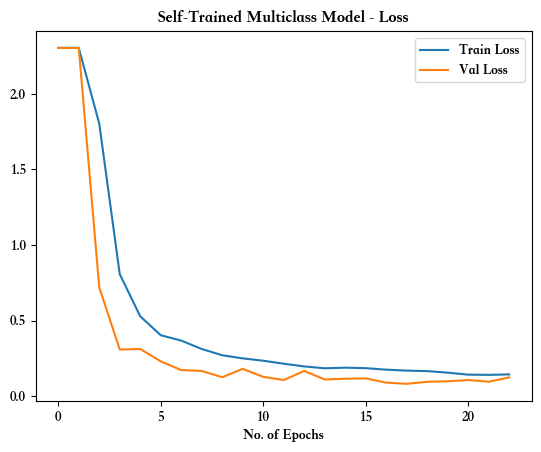

In [21]:
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Self-Trained Multiclass Model - Loss')
plt.xlabel('No. of Epochs')
plt.legend();

The validation loss measures the difference between the predicted values and the actual values in the validation dataset. A lower validation loss indicates that the model's predictions are closer to the actual values. In this case, the validation loss is very close to the training loss, which means the model is performing well.

#### 3.8.2 Accuracy over training epochs

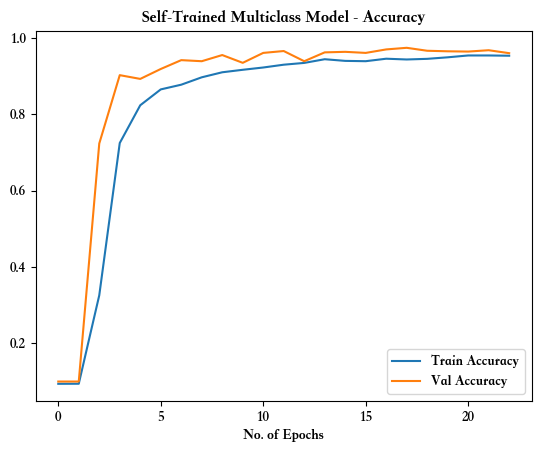

In [22]:
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Self-Trained Multiclass Model - Accuracy')
plt.xlabel('No. of Epochs')
plt.legend();

The validation accuracy is generally higher than the train accuracy during the training process. Towards the final epoch, the 2 accuracy scores are almost identical. This could mean that we will need to adjust the regularization made to the model to tackle the slight issue of underfitting.

#### 3.8.3 AUC over training epochs

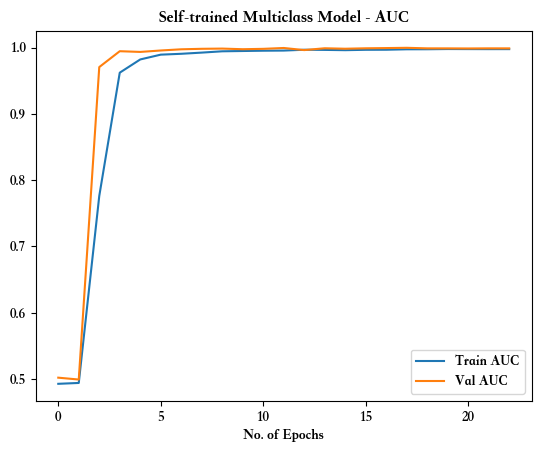

In [23]:
plt.plot(history_cnn.history['auc'], label='Train AUC')
plt.plot(history_cnn.history['val_auc'], label='Val AUC')
plt.title('Self-trained Multiclass Model - AUC')
plt.xlabel('No. of Epochs')
plt.legend();

AUC is a measure of the ability of a classifier to distinguish between clsses. The higher the AUC, the better the model's performance, with a perfect AUC score being 1. In this aspect, the model is performing very well as it has the almost perfect score of 1.

#### 3.8.4 Summary of Metrics

We will compile these metrics in [05_SVM_Multiclass](05_SVM_Multiclass.ipynb) to do a comparison across all baseline models.

In [24]:
summary_metrics = {}

summary_metrics['Train loss'] = history_cnn.history['loss'][-1]
summary_metrics['Val loss'] = history_cnn.history['val_loss'][-1]
summary_metrics['Train accuracy'] = history_cnn.history['accuracy'][-1]
summary_metrics['Val accuracy'] = history_cnn.history['val_accuracy'][-1]
summary_metrics['Train AUC'] = history_cnn.history['auc'][-1]
summary_metrics['Val AUC'] = history_cnn.history['val_auc'][-1]

print('Summary of metrics for Self-Trained Multiclass Model')
print(summary_metrics)

Summary of metrics for Self-Trained Multiclass Model
{'Train loss': 0.14485211670398712, 'Val loss': 0.12519174814224243, 'Train accuracy': 0.9532943964004517, 'Val accuracy': 0.9599719047546387, 'Train AUC': 0.9975926876068115, 'Val AUC': 0.9987270832061768}


#### 3.8.5 Confusion Matrix

A confusion matrix shows the detailed breakdown of the model's predictions and the actual classes.

In [25]:
# Make predictions on the test data
predictions = model_cnn.predict(val_generator)

# Extract true labels
y_true = val_generator.classes

# Extract predicted labels
y_pred = np.argmax(predictions, axis=1)

 1/89 [..............................] - ETA: 16s

2024-05-09 13:36:42.309442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


89/89 [==============================] - 1s 13ms/step


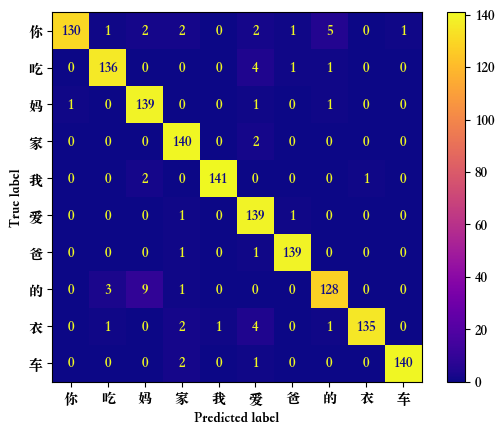

In [28]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
            display_labels=['你', '吃', '妈', '家', '我',
            '爱','爸', '的', '衣', '车'])
disp.plot(cmap='plasma')
plt.show()

The diagonal line from top left to bottom right represents the true positives (data that was correctly predicted). The diagonal line is almost all yellow, which is the higher end of the spectrum. The number of data outside of the diagonal line is mostly under 5. This shows that the model is able to produce a very accurate prediction.

### 3.9 Summary

Based on the above metrics, this self-trained multiclass model is performing reasonably well for unseen data. For comparison purposes, we will look into a few more baseline models in the next two notebooks [04_Pre_Trained_Model_Multiclass](04_Pre_Trained_Model_Multiclass.ipynb) and [05_SVM_Multiclass](05_SVM_Multiclass.ipynb).        